In [28]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
#import data related libraries
import pandas as pd
import numpy as np

# import plotting libraries
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
# import modelling libraries, and statistical libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA as ARIMA


In [2]:
import yfinance as yf
import pandas as pd

# Define the tickers
bitcoin_ticker = 'BTC-USD'
sp500_ticker = '^GSPC'

# Download the data
bitcoin_df = yf.download(bitcoin_ticker, start='2014-09-17', end='2024-08-23')
sp500_df = yf.download(sp500_ticker, start='2014-09-17', end='2024-08-23')

# Ensure both DataFrames have timezone-naive indices
bitcoin_df.index = bitcoin_df.index.tz_localize(None)
sp500_df.index = sp500_df.index.tz_localize(None)

# Rename columns to differentiate between datasets
bitcoin_df.columns = [f'BTC_{col}' for col in bitcoin_df.columns]
sp500_df.columns = [f'SP500_{col}' for col in sp500_df.columns]

# Combine DataFrames
df = pd.concat([sp500_df, bitcoin_df], axis=1, join='outer')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
df.rename(columns={'BTC_Adj Close':'Adj Close','BTC_Close':'Close'},inplace=True)

In [4]:
df.isnull().sum()

SP500_Open         1128
SP500_High         1128
SP500_Low          1128
SP500_Close        1128
SP500_Adj Close    1128
SP500_Volume       1128
BTC_Open              0
BTC_High              0
BTC_Low               0
Close                 0
Adj Close             0
BTC_Volume            0
dtype: int64

In [70]:
# Fill missing values using interpolation
df = df.interpolate(method='linear')

In [31]:
# Define the path where you want to save the CSV file
file_path = "C:\\Users\\Sarrang\\Desktop\\cleaned_BTC_sp_merged.csv"

# Export the DataFrame to a CSV file
df.to_csv(file_path)

print(f"Data exported successfully to {file_path}")


Data exported successfully to C:\Users\Sarrang\Desktop\cleaned_BTC_sp_merged.csv


In [71]:
df.isnull().sum()

SP500_Open         0
SP500_High         0
SP500_Low          0
SP500_Close        0
SP500_Adj Close    0
SP500_Volume       0
BTC_Open           0
BTC_High           0
BTC_Low            0
Close              0
Adj Close          0
BTC_Volume         0
dtype: int64

In [5]:
df.shape

(3628, 12)

C:\Users\Sarrang\AppData\Local\Temp\ipykernel_4292\420864510.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'] = df['Close'].replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')
C:\Users\Sarrang\AppData\Local\Temp\ipykernel_4292\420864510.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
C:\Users\Sarrang\AppData\Local\Temp\ipykernel_4292\420864510.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


Before Box-Cox Transformation:
KPSS Statistic: 6.386138749161185
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Data is likely non-stationary.

After Box-Cox Transformation:
KPSS Statistic: 8.345642275795983
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Data is likely non-stationary.


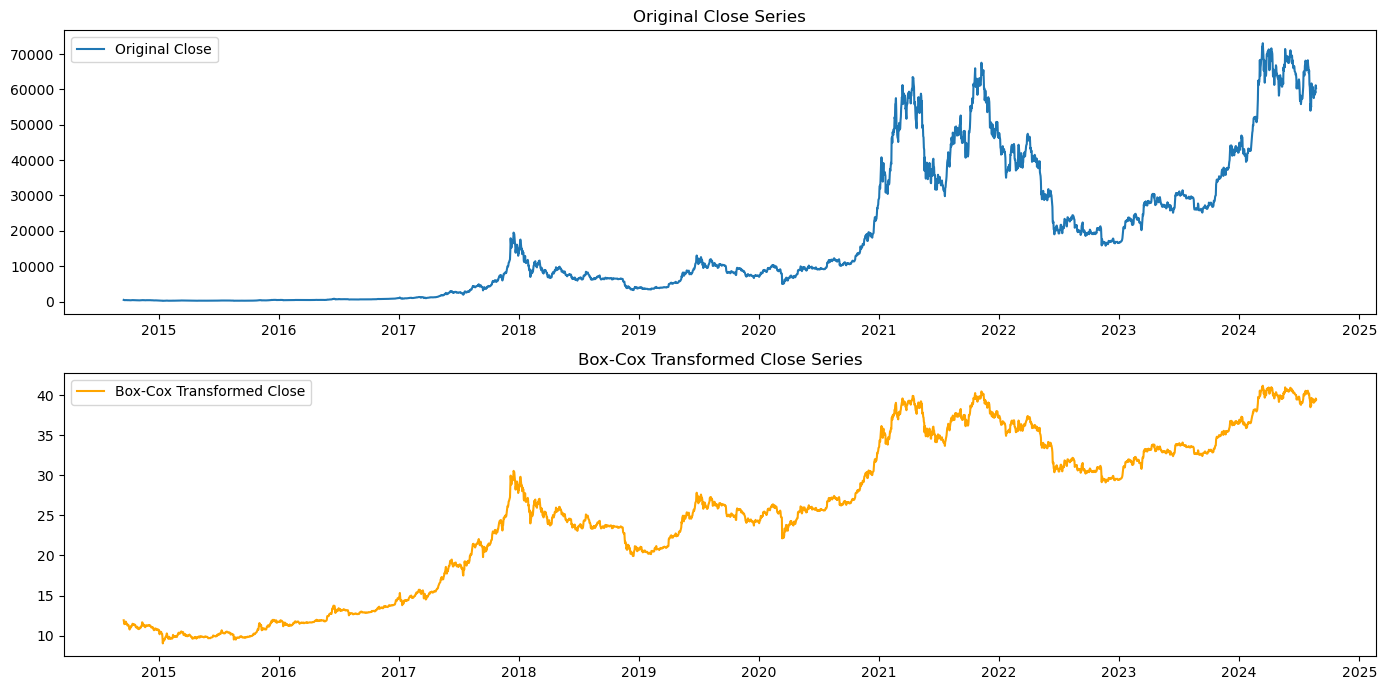

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from statsmodels.tsa.stattools import kpss
import matplotlib.pyplot as plt

# Ensure data is positive for Box-Cox
df['Close'] = df['Close'].replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')

# Check stationarity using KPSS test
def check_stationarity_kpss(series):
    result = kpss(series.dropna(), regression='c')
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:', result[3])
    if result[1] < 0.05:
        print("Data is likely non-stationary.")
    else:
        print("Data is likely stationary.")

# Check stationarity of the 'Close' series before transformation
print("Before Box-Cox Transformation:")
check_stationarity_kpss(df['Close'])

# Apply Box-Cox transformation
df['Close_BoxCox'], lambda_param = boxcox(df['Close'])

# Check stationarity of the transformed 'Close' series
print("\nAfter Box-Cox Transformation:")
check_stationarity_kpss(df['Close_BoxCox'])

# Plot the original and transformed series
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Original Close')
plt.title('Original Close Series')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['Close_BoxCox'], label='Box-Cox Transformed Close', color='orange')
plt.title('Box-Cox Transformed Close Series')
plt.legend()

plt.tight_layout()
plt.show()


After Differencing of Box-Cox Transformed Series:
KPSS Statistic: 0.06713628682006124
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Data is likely stationary.


C:\Users\Sarrang\AppData\Local\Temp\ipykernel_4292\420864510.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


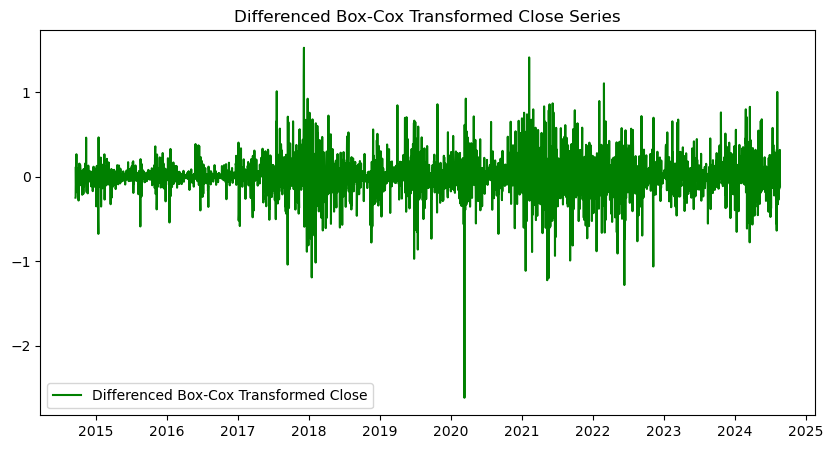

In [7]:
# Apply differencing
df['Close_BoxCox_Diff'] = df['Close_BoxCox'].diff().dropna()

# Check stationarity of the differenced series
print("After Differencing of Box-Cox Transformed Series:")
check_stationarity_kpss(df['Close_BoxCox_Diff'].dropna())

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(df['Close_BoxCox_Diff'], label='Differenced Box-Cox Transformed Close', color='green')
plt.title('Differenced Box-Cox Transformed Close Series')
plt.legend()
plt.show()


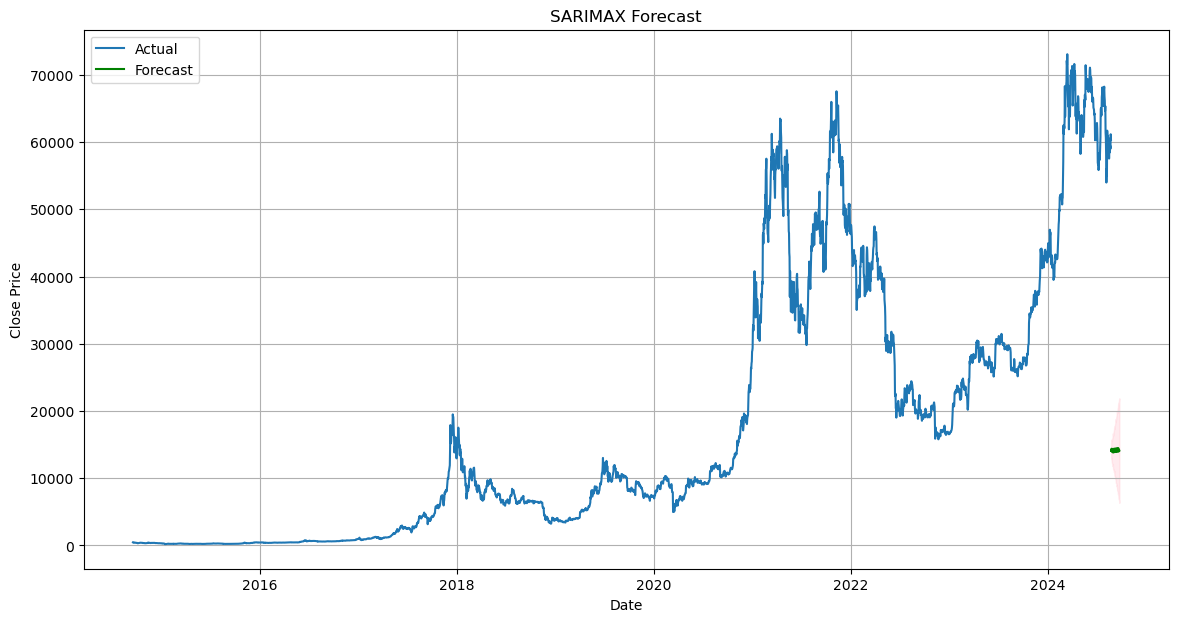

In [58]:
import matplotlib.pyplot as plt

# Proceed with forecasting using the cleaned future_exog
try:
    # Forecast with the exogenous data
    forecast = sariMax.get_forecast(steps=len(future_dates), exog=future_exog)
    forecast_mean = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()

    # Plot the forecast
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Actual')
    plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='green')
    plt.fill_between(forecast_conf_int.index, 
                     forecast_conf_int.iloc[:, 0], 
                     forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.legend()
    plt.title('SARIMAX Forecast')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error during forecasting: {e}")


## LSTM

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
# df = pd.read_csv('path_to_your_combined_dataset.csv', index_col='Date', parse_dates=True)
btc_close = df['Close'].values.reshape(-1, 1)

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
btc_scaled = scaler.fit_transform(btc_close)

In [ ]:
# Define a function to create sequences of data
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(x), np.array(y)

# Create sequences
seq_length = 60
x, y = create_sequences(btc_scaled, seq_length)

# Split the data into training and testing sets
train_size = int(len(x) * 0.8)
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]


#### Simple lstm
The model is a two-layer LSTM architecture with 50 units in each LSTM layer, incorporating Dropout for regularization, followed by two Dense layers for processing and producing a single output value, making it suitable for sequence-to-value prediction tasks.

In [ ]:
# Build the LSTM model
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(units=25))
# model.add(Dense(units=1))

In [ ]:
# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(x_train, y_train, batch_size=32, epochs=10)

In [ ]:
# # Make predictions
# y_pred = model.predict(x_test)
# y_pred = scaler.inverse_transform(y_pred)

# # Inverse scaling for actual values
# y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# # Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred))
# print(f'RMSE: {rmse}')


In [11]:
# # Assuming your original dataset has a DateTime index and you've split your test set
# test_dates = df.index[-len(x_test):]  # Adjust the slicing as per your test data length

# # Make predictions using the LSTM model
# y_pred = model.predict(x_test)

# # Inverse scale the predictions if they were scaled during preprocessing
# y_pred_inv = scaler.inverse_transform(y_pred)
# y_test_inv = scaler.inverse_transform(y_test)

# # Convert predictions and actual values to a DataFrame for easier comparison
# forecast_results = pd.DataFrame({
#     'Forecast': y_pred_inv.flatten(),
#     'Actual': y_test_inv.flatten()
# }, index=test_dates)

# # Calculate RMSE between the actual and predicted values
# rmse = np.sqrt(np.mean((forecast_results['Forecast'] - forecast_results['Actual'])**2))
# print(f"RMSE: {rmse}")

# # Display the forecast results
# print(forecast_results)


In [13]:
# import numpy as np
# import pandas as pd

# def forecast_future_prices(model, scaler, data, n_days, look_back=60):
#     # Extract only the 'Close' column
#     close_data = data['Close']

#     # Extract the last `look_back` days from the 'Close' column
#     last_data = close_data[-look_back:].values.reshape(-1, 1)
#     last_data_scaled = scaler.transform(last_data)

#     predictions = []

#     for _ in range(n_days):
#         # Prepare the input for the model
#         input_data = last_data_scaled[-look_back:].reshape(1, look_back, 1)

#         # Generate the prediction
#         pred_scaled = model.predict(input_data)
#         pred = scaler.inverse_transform(pred_scaled)

#         # Append the prediction to the results
#         predictions.append(pred[0, 0])

#         # Update the last_data_scaled with the predicted value for the next iteration
#         last_data_scaled = np.append(last_data_scaled, pred_scaled).reshape(-1, 1)

#     # Create a DataFrame for the forecast results
#     future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_days, freq='D')
#     forecast_df = pd.DataFrame({
#         'Forecast': predictions
#     }, index=future_dates)

#     return forecast_df

# # Example usage
# n_days = 7  # User specifies the number of days in advance to predict
# forecast_df = forecast_future_prices(model, scaler, df, n_days)
# print(forecast_df)


In [14]:
# from tensorflow.keras.models import save_model

# # Save the model
# model.save('lstm_btc_model.h5')

In [15]:
# from tensorflow.keras.models import load_model

# # Load the model
# loaded_model = load_model('lstm_btc_model.h5')
# print("Model loaded from 'lstm_btc_model.h5'")

## improving the lstm

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

def build_improved_lstm_model(input_shape):
    model = Sequential()
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=input_shape)))
    model.add(Dropout(0.2))
    
    # Stacked LSTM layers
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    
    # Output layer
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return model


In [17]:
look_back = 10  # Number of previous time steps to use for predicting the next time step
num_features = 14  # Number of features in your input data

In [21]:
# Assuming X_train and y_train are prepared
model = build_improved_lstm_model(input_shape=(look_back, num_features))
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


C:\Users\Sarrang\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - loss: 0.0023 - val_loss: 0.0038
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 2.8656e-04 - val_loss: 0.0093
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 2.9654e-04 - val_loss: 0.0018
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 1.7835e-04 - val_loss: 0.0053
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 2.8523e-04 - val_loss: 0.0015
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1.4667e-04 - val_loss: 0.0043
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 1.8255e-04 - val_loss: 0.0012
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 1.3505e-04 - val_loss: 0.0012
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 1.1632e-04 - val_loss: 0.0021
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 1.6033e-04 - val_loss: 0.0015
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 1.9571e-04 - val_loss: 0.0039
Epoch 12/20
72/72 ━━━━━━━━━━━━━━━

In [22]:
# Assuming X_test and y_test are prepared
y_pred = model.predict(x_test)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print(f'RMSE: {rmse}')


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
RMSE: 0.02678962605742662


In [23]:
import numpy as np
import pandas as pd

def forecast_future_prices(model, scaler, data, n_days, look_back=60):
    # Extract only the 'Close' column
    close_data = data['Close']

    # Extract the last `look_back` days from the 'Close' column
    last_data = close_data[-look_back:].values.reshape(-1, 1)
    last_data_scaled = scaler.transform(last_data)

    predictions = []

    for _ in range(n_days):
        # Prepare the input for the model
        input_data = last_data_scaled[-look_back:].reshape(1, look_back, 1)

        # Generate the prediction
        pred_scaled = model.predict(input_data)
        pred = scaler.inverse_transform(pred_scaled)

        # Append the prediction to the results
        predictions.append(pred[0, 0])

        # Update the last_data_scaled with the predicted value for the next iteration
        last_data_scaled = np.append(last_data_scaled, pred_scaled).reshape(-1, 1)

    # Create a DataFrame for the forecast results
    future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_days, freq='D')
    forecast_df = pd.DataFrame({
        'Forecast': predictions
    }, index=future_dates)

    return forecast_df

# Example usage
n_days = 7  # User specifies the number of days in advance to predict
forecast_df = forecast_future_prices(model, scaler, df, n_days)
print(forecast_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
                Forecast
2024-08-23  62258.765625
2024-08-24  62854.453125
2024-08-25  63552.476562
2024-08-26  64306.460938
2024-08-27  65076.816406
2024-08-28  65833.148438
2024-08-29  66549.367188


In [29]:
model.save('lstm_btc_V1.h5')

In [1]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [26]:
x.shape

(3568, 60, 1)

In [27]:
y.shape

(3568, 1)